In [2]:
import numpy as np
import pandas as pd
import torch
import pickle
from skimage import io
import random

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [ ]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

In [5]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [6]:
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224
DEVICE = torch.device("cuda")

# Dataset construction

In [7]:
class ButterflyDataset(Dataset):
    def __init__(self, files, mode, augmentations = None):
        super().__init__()
        self.files = files
        self.mode = mode
        self.augmentations = augmentations

        if self.mode not in DATA_MODES:
            print(f'wrong mode: {self.mode}')
            raise NameError

        self.len_ = len(self.files)
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            d = pd.read_csv("final_data/train_labels.csv")
            self.labels = [str(int(d[d.filenames=='train/{}'.format(path.name)].label))\
                          for path in self.files]
            
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump:
                pickle.dump(self.label_encoder, le_dump)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        transform = transforms.Compose([
              transforms.ToTensor(),
              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])                                
            ])
    # трансформации для шума
        custom_augmentations_01 = transforms.RandomOrder([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomApply([transforms.RandomRotation(degrees=10)], p=0.25),
            transforms.RandomApply([transforms.RandomResizedCrop(224, scale=(0.8, 1.25), ratio=(0.8, 1.25))], p=0.25),
            transforms.RandomApply([transforms.RandomAffine((-10,10), (0.1,0.1))], p=0.25),
            transforms.RandomPerspective(distortion_scale=0.1, p=0.25),
            transforms.RandomApply([transforms.ColorJitter(brightness=0.02,contrast=0.02,saturation=0.02,hue=(-0.02, 0.02))], p=0.01)
        ])

        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
    #x = np.array(x / 255, dtype='float32')

    
        if self.mode == 'test':
            x = np.array(x)
            x = np.array(x / 255, dtype='float32')
            x = transform(x)
            return x
        else:
        
            if self.mode == 'train':
                x = custom_augmentations_01(x)
            
            x = transform(x)
        
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return image #np.array(image)

In [8]:
TRAIN_DIR = Path('final_data/train')
TEST_DIR = Path('final_data/test')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [9]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

d = pd.read_csv("final_data/train_labels.csv")
train_val_labels = [str(int(d[d.filenames=='train/{}'.format(path.name)].label))\
                          for path in train_val_files]
# train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.3, stratify=train_val_labels)

train_files = shuffle(train_val_files, random_state=0) #!!!

val_dataset = ButterflyDataset(val_files, mode='val')
train_dataset = ButterflyDataset(train_files, mode='train')

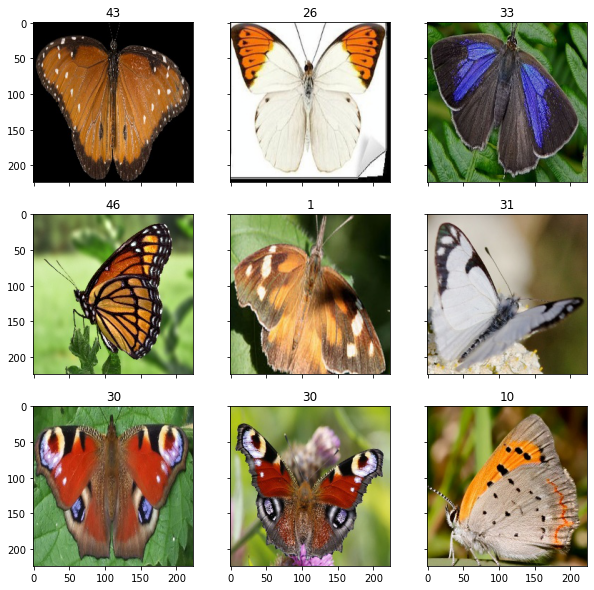

In [10]:
def imshow(img, title=None, plt_ax=plt, default=False):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt_ax.imshow(img)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10,10), sharex=True, sharey=True)

for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    

# Building the model

In [11]:
from torchvision import models

model = models.resnet34(pretrained=True)
#model = models.resnet18(pretrained=True)

In [12]:
for param in model.parameters():
    param.requires_grad = True
    
model.fc = nn.Linear(in_features=model.fc.in_features, out_features=50)

In [13]:
model = model.to(DEVICE)

In [14]:
import math

def cyclical_lr(stepsize, min_lr=1e-3, max_lr=1e-2):
    
    scaler = lambda x: 1.
    
    def relative(it, stepsize):
        cycle = math.floor(1 + it / (2 * stepsize))
        x = abs(it / stepsize - 2 * cycle + 1)
        return max(0, (1 - x)) * scaler(cycle)
    
    lr_lambda = lambda it: min_lr + (max_lr - min_lr) * relative(it, stepsize)
    print('cycle')
    return lr_lambda

In [15]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()
        scheduler.step()
        
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc
  
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc
  
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        criterion = nn.CrossEntropyLoss()
        #opt = torch.optim.SGD(model.parameters(), lr=1.)
        opt = torch.optim.Adam(model.parameters())
        step_size = 10*len(train_loader)
        clr = cyclical_lr(step_size)
        clr_scheduler = torch.optim.lr_scheduler.LambdaLR(opt, [clr])

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt, clr_scheduler)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [16]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

# Training

In [ ]:
history = train(train_dataset, val_dataset, model=model, epochs=13, batch_size=64)

epoch:   0%|                                                                                    | 0/13 [00:00<?, ?it/s]C:\Users\kamelis\AppData\Roaming\Python\Python38\site-packages\torchvision\transforms\functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  ..\aten\src\ATen\LegacyTHFunction

cycle


C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


loss 4.135736958352118


epoch:   8%|█████▊                                                                     | 1/13 [02:49<33:56, 169.73s/it]


Epoch 001 train_loss: 4.1357     val_loss 4.0666 train_acc 0.0186 val_acc 0.0213
loss 3.833079722682625


epoch:  15%|███████████▌                                                               | 2/13 [05:27<29:47, 162.47s/it]


Epoch 002 train_loss: 3.8331     val_loss 3.5948 train_acc 0.0508 val_acc 0.1233
loss 3.1295648469825155


epoch:  23%|█████████████████▎                                                         | 3/13 [08:04<26:41, 160.19s/it]


Epoch 003 train_loss: 3.1296     val_loss 2.3157 train_acc 0.2432 val_acc 0.4490
loss 1.5538914699157789


epoch:  31%|███████████████████████                                                    | 4/13 [10:16<22:22, 149.13s/it]


Epoch 004 train_loss: 1.5539     val_loss 0.8921 train_acc 0.6019 val_acc 0.7585
loss 0.7227333255661602


epoch:  38%|████████████████████████████▊                                              | 5/13 [11:52<17:17, 129.70s/it]


Epoch 005 train_loss: 0.7227     val_loss 0.4913 train_acc 0.7982 val_acc 0.8622
loss 0.4562823297829006


epoch:  46%|██████████████████████████████████▌                                        | 6/13 [13:26<13:44, 117.85s/it]


Epoch 006 train_loss: 0.4563     val_loss 0.3292 train_acc 0.8696 val_acc 0.9090


In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

In [ ]:
fig = plt.figure(figsize=(20, 15))

losses = fig.add_subplot(2,2,3)
losses.plot(loss.cpu(), label="train_loss")
losses.plot(val_loss.cpu(), label="val_loss")
losses.legend(loc='best')
losses.grid(axis = 'y')
losses.set_xlabel("epochs")
losses.set_ylabel("loss")

accs = fig.add_subplot(2,2,4)
accs.plot(acc.cpu(), label="train_acc")
accs.plot(val_acc.cpu(), label="val_acc")
accs.legend(loc='best')
accs.grid(axis = 'y')
accs.set_xlabel("epochs")
accs.set_ylabel("accuracy")

plt.show()

# Submission

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

test_dataset = ButterflyDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
submit.head()
sub = pd.DataFrame({'label': preds})
sub.head()

In [ ]:
sub.to_csv('submit3.csv', index=False)